In [18]:
using GpABC,OrdinaryDiffEq, Distances, Distributions, Plots, StatsBase, Printf, ODE, DifferentialEquations, Statistics, ModelingToolkit, CSV
using DelimitedFiles, StatsPlots, Suppressor
import Base.Iterators
include("setup_ABC.jl")
gr()

function log_euclidean(x,y)
    output = sqrt(sum((log10.(x.+0.00001) - log10.(y.+0.00001)) .^ 2))
    return (output/size(x)[1]) #average by the length of the vector
end

┌ Info: Precompiling Suppressor [fd094767-a336-5f1f-9728-57cf17d0bbfb]
└ @ Base loading.jl:1273


log_euclidean (generic function with 1 method)

In [71]:
@parameters t

@variables s_out(t) rmr(t) em(t) rmq(t) rmt(t) et(t) rmm(t) mt(t) mm(t) q(t) si(t) mq(t) mr(t) r(t) NH4(t) nit_mrna(t) nit_mrna_ribo(t) nit(t) NH4_ex(t) N(t) a(t) AA(t) AA_prot(t) AA_mrna(t) AA_mrna_ribo(t)

#############check the last parameter k_ribo_a
###############

@parameters k_cat_AA k_a_NH4 k_NH4 k_a_AA k_NH4_AA k_a #these are the parameters to be varied in ABC
gam= (gmax*a*AA)/(k_ribo_a*k_ribo_a_AA+k_ribo_a_AA*a+k_ribo_AA_a*AA+a*AA) #updated gamma equation that uses both ATP and AA
ttrate= (rmq + rmr + rmt + rmm + nit_mrna_ribo+AA_mrna_ribo)*gam #total translation rate (sum of the mRNA/ribosome complexes times translation rate)
lam= ttrate/M #lambda is the growth rate
nucat= em*vm*si/(Km + abs(si))
AA_vo = ((k_cat_AA*2*a*NH4)/(k_a_NH4*k_a))/(1+(1+(AA/k_a_AA))+(NH4/k_a_NH4)+(1+(AA/k_NH4_AA))+(NH4/k_NH4))
new_AA = AA_vo*AA_prot
AA_a_use = new_AA*2 #each AA produced uses x number of ATP molecules
AA_NH4_use = new_AA*2 #each AA produced uses 2 NH4 molecules
export_rate = 0 #export rate of NH4
fixation = 0
death_rate = 0
k_ribo_a_AA = 10000.0
k_ribo_AA_a = 10000.0
k_ribo_a = 10.0

@derivatives D'~t

eqs = [
    D(s_out)~ 0 #((-et*vt*s_out/(Kt+s_out))*N)-ds*s_out+(export_rate*NH4*50)+1e7
    D(rmr)~ kb*r*mr-ku*rmr-(gam/nr)*rmr-lam*rmr
    D(em)~ (gam/nx)*rmm-lam*em
    D(rmq)~ kb*r*mq-ku*rmq-(gam/nx)*rmq-lam*rmq
    D(rmt)~ kb*r*mt-ku*rmt-gam/nx*rmt-lam*rmt
    D(et)~ (gam/nx)*rmt-lam*et
    D(rmm)~ kb*r*mm-ku*rmm-gam/nx*rmm-lam*rmm
    D(mt)~ (we*a/(thetax+a))+ku*rmt+(gam/nx)*rmt-kb*r*mt-dm*mt-lam*mt
    D(mm)~ (we*a/(thetax+a))+ku*rmm+(gam/nx)*rmm-kb*r*mm-dm*mm-lam*mm
    D(q)~ (gam/nx)*rmq-lam*q
    D(si)~ (et*vt*s_out/(Kt+s_out))-nucat-lam*si
    D(mq)~ (wq*a/(thetax+a)/(1+(q/Kq)^nq))+ku*rmq+(gam/nx)*rmq-kb*r*mq-dm*mq-lam*mq
    D(mr)~ (wr*a/(thetar+a))+ku*rmr+(gam/nr)*rmr-kb*r*mr-dm*mr-lam*mr
    D(r)~ ku*rmr+ku*rmt+ku*rmm+ku*rmq+(gam/nr)*rmr+(gam/nr)*rmr+(gam/nx)*rmt+(gam/nx)*rmm+(gam/nx)*rmq-kb*r*mr-kb*r*mt-kb*r*mm-kb*r*mq+ku*nit_mrna_ribo+(gam/nx)*nit_mrna_ribo-kb*r*nit_mrna+ku*AA_mrna_ribo+(gam/nx)*AA_mrna_ribo-kb*r*AA_mrna-lam*r
    D(NH4)~ 0 #fixation*nit-export_rate*NH4-lam*NH4-AA_NH4_use+2.3e6
    D(nit_mrna)~ 0 #(v_nit*a/(thetax + a))+(ku*nit_mrna_ribo)+(gam/nx*nit_mrna_ribo)-(kb*r*nit_mrna)-(dm*nit_mrna)-(lam*nit_mrna) #num of free nitrogenase coding mRNA
    D(nit_mrna_ribo)~ 0 #(kb*r*nit_mrna)-(ku*nit_mrna_ribo)-(gam/nx*nit_mrna_ribo)-(lam*nit_mrna_ribo) #num of nit mRNA-ribosome complexes
    D(nit)~ 0 #(gam/nx)*nit_mrna_ribo-lam*nit #num of nitrogenase proteins
    D(NH4_ex)~ 0 #(export_rate*NH4)#total num of NH4 molecules exported this timestep
    D(N)~ 0 #lam*N-death_rate*N #the change in num of bacterial cells instead of just loss to dilution
    D(a)~ ns*nucat-ttrate-fixation*nit-AA_a_use-lam*a
    D(AA)~ new_AA-ttrate-lam*AA
    D(AA_prot)~ (gam/nx)*AA_mrna_ribo-lam*AA_prot
    D(AA_mrna)~ ((w_AA*a/(thetax+a)))+(ku*AA_mrna_ribo)+(gam/nx*AA_mrna_ribo)-(kb*r*AA_mrna)-(dm*AA_mrna)-(lam*AA_mrna)
    D(AA_mrna_ribo)~ (kb*r*AA_mrna)-(ku*AA_mrna_ribo)-(gam/nx*AA_mrna_ribo)-(lam*AA_mrna_ribo)
];

println("System defined successfully")

System defined successfully


burning in model
success


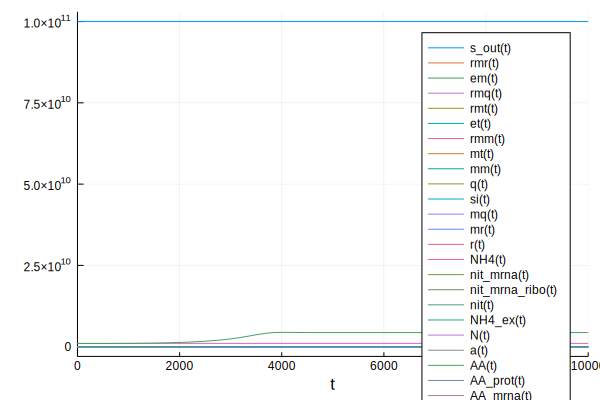

In [72]:
de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
        et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
        nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot,
        AA_mrna, AA_mrna_ribo],[k_cat_AA,k_a_NH4 ,k_NH4, k_a_AA, k_NH4_AA, k_a])

f = ODEFunction(de)
p = [10.0,10.0,10.0,10.0,10.0,10.0]
burn_in_prob_abc = ODEProblem(f, init, (0.,10000.0),p) #set up the burn in problem

println("burning in model")
sol = solve(burn_in_prob_abc)
println("success")
step_num = size(sol,2)
final_state =sol[step_num]; #run the burn in stage and collect the end state to use as new initial values

prob_abc = ODEProblem(f, final_state, (0.,10000.0),p) #the problem to run ABC on using the burned in initial values
sol2 = solve(prob_abc)
plot(sol)#ylim = (0,20000))
# plot!(log10.(sol2.+0.00001))


In [43]:
# params = [10.0,10.0,10.0,10.0,10.0,10.0]

function simulator_function_lm(params, time1= 10000.0)
    global k_cat_AA =10. #params[1]
    global k_a_NH4 = 10.#params[2]
    global k_NH4 = params[1]
    global k_a_AA = params[2]
    global k_NH4_AA = 10.#params[5]
    global k_a = 10. #params[6]
    prob = ODEProblem(AA_simple, final_state,(0., time1),params)
    sol = solve(prob, saveat = 1.)
    return Array{Float64, 2}(sol)
end

simulator_function_lm (generic function with 2 methods)

In [44]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]

threshold_schedule = [0.005,0.001, 0.0007, 0.0005, 0.0001,0.00005];
priors = [Uniform(0., 20.0), Uniform(0.,20.0)]#, Uniform(0., 20.0)]#,
#     Uniform(2., 30.), Uniform(2., 30.), Uniform(2., 30.)]
n_particles = 300

real_param_vect1 = []
real_param_vect2 = []
difference_vect2 = []
final_popns1 = []
final_popns2 = []

0-element Array{Any,1}

In [46]:
for i in range(1,stop = 15)

#generate dummy data with 1 random param between 0 and 20
params_lm = rand(2)*20
results = simulator_function_lm(params_lm);

#run abc smc to try and recreate the 1 random param value
sim_abcsmc_res = SimulatedABCSMC(results,
    simulator_function_lm,
    priors,
    threshold_schedule,
    n_particles,
    distance_function = log_euclidean,
    max_iter=convert(Int, 2e6),
    write_progress=true)

mean1 = mean(sim_abcsmc_res.population[6][:,1])
mode1 = mode(sim_abcsmc_res.population[6][:,1])
println("estimated paramter mean is $mean1, mode is $mode1")
mean2 = mean(sim_abcsmc_res.population[6][:,2])
mode2 = mode(sim_abcsmc_res.population[6][:,2])
println("estimated paramter mean is $mean2, mode is $mode2")
println("true parameters are $params_lm")
push!(real_param_vect1, params_lm[1])
push!(real_param_vect2, params_lm[2])
println("difference for round $i is")
println(euclidean([mean1,mean2],params_lm))
push!(difference_vect2,euclidean([mean1,mean2],params_lm))
    #save the final populations of the two parameters
push!(final_popns1, sim_abcsmc_res.population[6][:,1])
push!(final_popns2, sim_abcsmc_res.population[6][:,2])
end

┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 7.829879810541758, mode is 9.968663070592733
estimated paramter mean is 8.387471225931868, mode is 5.477695838526115
true parameters are [4.755892033306126, 5.32423436463346]
difference for round 1 is


┌ Info: GpABC SMC simulation accepted 222/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


4.339679818029365


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 13.196641449557939, mode is 13.47804622018856
estimated paramter mean is 10.946570075219736, mode is 18.066201048701267
true parameters are [11.694011241805322, 13.42637384780149]
difference for round 2 is
2.8995386342936302


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 6.735728241765069, mode is 13.896146233897452
estimated paramter mean is 12.649134463611906, mode is 13.92605094319999
true parameters are [2.271509358431767, 19.445745652938157]
difference for round 3 is
8.131615700288869


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 184/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 7.822313796615761, mode is 14.230986004280538
estimated paramter mean is 2.272078304978645, mode is 1.8060615867624845
true parameters are [10.840924582146286, 1.651022868315577]
difference for round 4 is
3.0818372653224193


┌ Info: GpABC SMC simulation accepted 294/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 8.609996625885456, mode is 12.225548310536194
estimated paramter mean is 14.213506452849566, mode is 16.97085777531762
true parameters are [8.7275587158644, 19.84277835921972]
difference for round 5 is
5.6304993598124575


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 9.792072950738069, mode is 9.209793861235184
estimated paramter mean is 11.901764318139328, mode is 8.025335193752428
true parameters are [5.483975822100349, 19.447011711527647]
difference for round 6 is
8.688524563883663


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 7.117981643755079, mode is 5.27770205624498
estimated paramter mean is 14.096397108753223, mode is 8.35389270112161
true parameters are [6.8438773582653445, 9.230094038125554]
difference for round 7 is
4.874016694116273


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 8/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 14/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 18/3000 particles.
└ @

estimated paramter mean is 1.3507499412672674, mode is 0.37161959206950573
estimated paramter mean is 8.442895960866508, mode is 2.6435316224344643
true parameters are [17.29283330107725, 0.2990283120516324]
difference for round 8 is
17.90174857751454


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 12.506780425454274, mode is 8.045388915670104
estimated paramter mean is 13.246007669031705, mode is 19.35555057869355
true parameters are [19.74750916289933, 11.945732472391661]
difference for round 9 is
7.356552741349714


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 9.010217929018369, mode is 10.581738253174823
estimated paramter mean is 13.6512562958529, mode is 19.774096427049827
true parameters are [10.088877351598718, 13.963087082290615]
difference for round 10 is
1.1228288334789667


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 21/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 45/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 64/3000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 82/4

estimated paramter mean is 6.191447894946198, mode is 15.614977230669885
estimated paramter mean is 1.8369232300145426, mode is 0.30477255632254874
true parameters are [5.429201219670587, 0.3225310113360669]
difference for round 11 is
1.6954066727374404


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 7.840319161745694, mode is 17.837457070285076
estimated paramter mean is 7.11456953779697, mode is 4.469536765032039
true parameters are [17.05018631930053, 4.204561327502616]
difference for round 12 is
9.65866454763741


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 8.889728303507688, mode is 12.675132009921107
estimated paramter mean is 5.531692684411793, mode is 5.741485592797927
true parameters are [2.339822167870196, 5.96011433554644]
difference for round 13 is
6.563902459423251


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 10.539683175353126, mode is 6.19877005443927
estimated paramter mean is 4.955430464442066, mode is 5.877952284711914
true parameters are [1.2721816011788922, 18.802381766998572]
difference for round 14 is
16.662072074105705


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 11.38153295216702, mode is 14.989715589222193
estimated paramter mean is 14.579783575891575, mode is 13.312848540449451
true parameters are [11.793186688950863, 16.201018516194328]
difference for round 15 is
1.6726809410842733


In [47]:
writedlm("20_04_14_ABC_SMC_final_popn1.txt", final_popns1, ",")
writedlm("20_04_14_ABC_SMC_final_popn2.txt", final_popns2, ",")
writedlm("20_04_14_ABC_SMC_difference_vect_2_params.txt", difference_vect2, ",")
writedlm("20_04_14_ABC_SMC_real_params1.txt", real_param_vect1, ",")
writedlm("20_04_14_ABC_SMC_real_params2.txt", real_param_vect2, ",")

In [59]:
final_popns1= Array(CSV.read("20_04_14_ABC_SMC_final_popn1.txt" ))
final_popns2= Array(CSV.read("20_04_14_ABC_SMC_final_popn2.txt" ))
difference_vect2= Array(CSV.read("20_04_14_ABC_SMC_difference_vect_2_params.txt" ))
real_param_vect1= Array(CSV.read("20_04_14_ABC_SMC_real_params1.txt" ))
real_param_vect2=Array(CSV.read("20_04_14_ABC_SMC_real_params2.txt" ));

In [60]:
param2_run1=final_popns2[1,:]
param2_run2=final_popns2[2,:]
param2_run3=final_popns2[3,:]
param2_run4=final_popns2[4,:]
param2_run5=final_popns2[5,:]
param2_run6=final_popns2[6,:]
param2_run7=final_popns2[7,:]
param2_run8=final_popns2[8,:]
param2_run9=final_popns2[9,:];


In [62]:
inferred_ratio = [mean(param2_run1)/mean(param1_run1),mean(param2_run2)/mean(param1_run2),mean(param2_run3)/mean(param1_run3),mean(param2_run4)/mean(param1_run4),
        mean(param2_run5)/mean(param1_run5),mean(param2_run6)/mean(param1_run6),mean(param2_run7)/mean(param1_run7),mean(param2_run8)/mean(param1_run8),
mean(param2_run9)/mean(param1_run9)];
real_ratio = []
for i in (1:9)
 push!(real_ratio, real_param_vect2[i]/real_param_vect1[i])
end

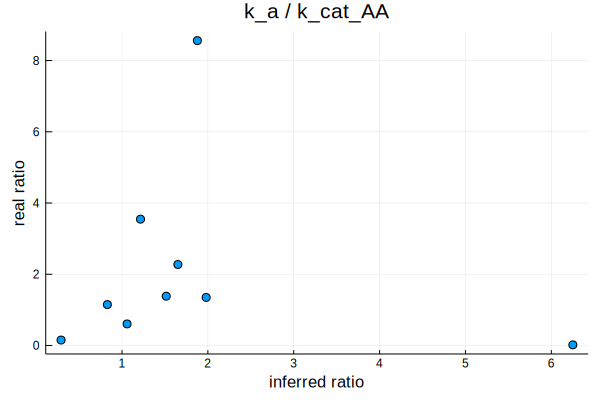

In [69]:
scatter(inferred_ratio, real_ratio,xlab = "inferred ratio", ylab = "real ratio", label = "", title = "k_a / k_cat_AA")

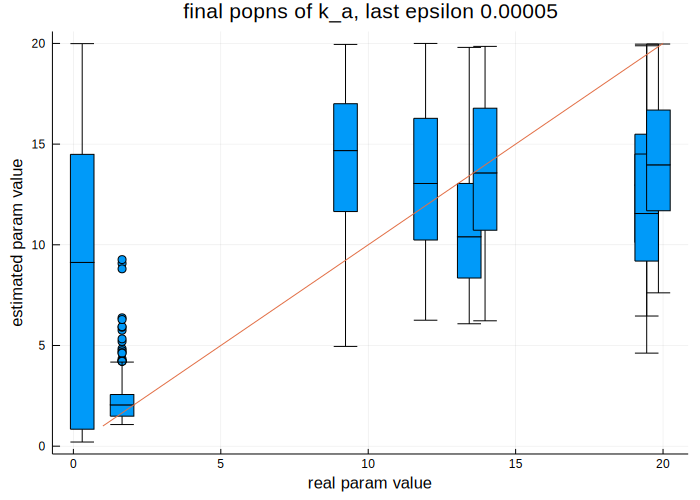

In [65]:
vals = []
for i in range(1,stop = 9)
    push!(vals,repeat([real_param_vect2[i]],outer = 300))
end
vals = collect(Iterators.flatten(vals))

# flatfinpops = collect(Iterators.flatten(final_popns2))
flatfinpops = collect(Iterators.flatten(Array([param2_run1,param2_run2,param2_run3,param2_run4,param2_run5,param2_run6,param2_run7,param2_run8,param2_run9])))

boxplot(vals,flatfinpops, label="", title = "final popns of k_a, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
plot!([1:20], label = "")

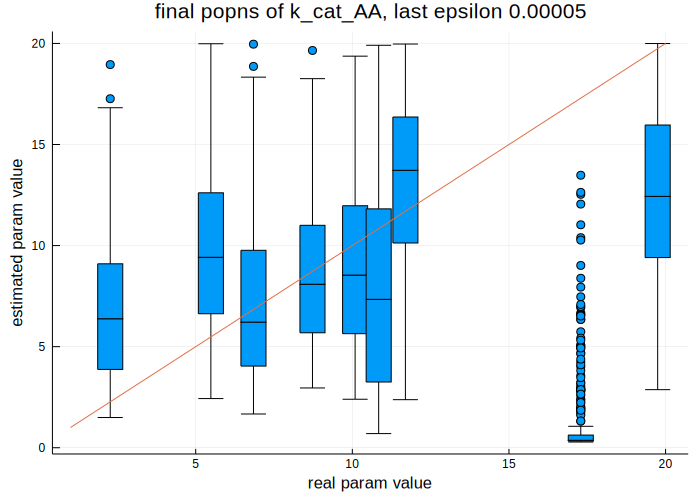

In [66]:
param1_run1=final_popns1[1,:]
param1_run2=final_popns1[2,:]
param1_run3=final_popns1[3,:]
param1_run4=final_popns1[4,:]
param1_run5=final_popns1[5,:]
param1_run6=final_popns1[6,:]
param1_run7=final_popns1[7,:]
param1_run8=final_popns1[8,:]
param1_run9=final_popns1[9,:];


vals = []
for i in range(1,stop = 9)
    push!(vals,repeat([real_param_vect1[i]],outer = 300))
end
vals = collect(Iterators.flatten(vals))

# flatfinpops = collect(Iterators.flatten(final_popns1))
flatfinpops = collect(Iterators.flatten(Array([param1_run1,param1_run2,param1_run3,param1_run4,param1_run5,param1_run6,param1_run7,param1_run8,param1_run9])))

boxplot(vals,flatfinpops, label="", title = "final popns of k_cat_AA, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
plot!([1:20], label = "")

In [57]:
# vals = []
# for i in range(1,stop = 10)
#     push!(vals,repeat([real_param_vect1[i]],outer = 300))
# end
# vals = collect(Iterators.flatten(vals))

# flatfinpops = collect(Iterators.flatten(final_popns1))

# boxplot(vals,flatfinpops, label="", title = "final popns of k_cat_AA, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
# plot!([1:20], label = "")

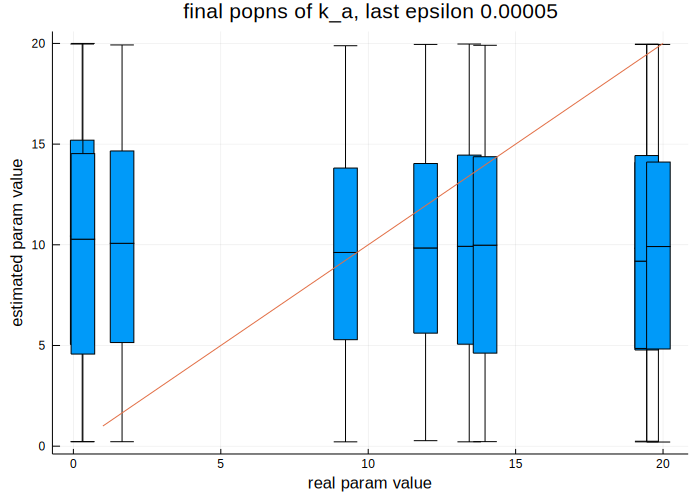

In [67]:
vals = []
for i in range(1,stop = 10)
    push!(vals,repeat([real_param_vect2[i]],outer = 300))
end
vals = collect(Iterators.flatten(vals))

flatfinpops = collect(Iterators.flatten(final_popns2))

boxplot(vals,flatfinpops, label="", title = "final popns of k_a, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
plot!([1:20], label = "")

In [68]:
final_popns1


14×300 Array{Float64,2}:
 13.478    18.1359    11.5618    12.4781    …  16.1381     4.22968    4.83228
 13.8961    8.36025   10.1977     2.85926       9.47463    4.89423    7.08658
 14.231     1.80186    4.91669    1.47932       2.5264    17.655      5.264  
 12.2255   11.6181    11.9787     7.3876       10.708     10.9788     3.74345
  9.20979   9.60807   13.7201    11.0017        5.03612    8.78203   15.5666 
  5.2777    6.35527   11.0445    10.6489    …  13.8527    12.4443     3.26596
  0.37162   0.319481   0.297683   0.332833      0.367328   0.365592   4.93551
  8.04539  16.2144    13.8355    17.5638       14.4949    10.7821     6.32491
 10.5817    7.00658    8.56694    7.07005       5.77       7.16491   16.6926 
 15.615     7.15239    1.51785    3.54911       4.20824   12.3411     5.5149 
 17.8375    3.50959    6.3626    16.2306    …   3.47604    2.22487    8.57481
 12.6751   13.6509    18.8658     4.54328       1.25837    8.6741     3.72178
  6.19877  13.6499     4.11771    4.121